## Library

In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore') # Hide all warnings
from pykalman import KalmanFilter

In [85]:
def rolling_linreg_slope(y: pd.Series, window: int = 20) -> pd.Series:
    """
    Rolling OLS slope of y ~ a + b*x over a window, where x = 0..window-1.
    Returns slope per bar.
    """
    y = y.astype(float)
    x = np.arange(window, dtype=float)

    x_mean = x.mean()
    x_demean = x - x_mean
    denom = np.sum(x_demean**2)  # constant for a fixed window

    def slope_last_window(y_window: np.ndarray) -> float:
        y_demean = y_window - y_window.mean()
        return float(np.dot(x_demean, y_demean) / denom)

    return y.rolling(window, min_periods=window).apply(slope_last_window, raw=True)

import numpy as np
import pandas as pd

def backtest_long_only_from_signal(
    df: pd.DataFrame,
    price_col: str = "Close",
    signal_col: str = "signal",
    fee: float = 0.0,          # e.g. 0.001 = 0.10% per trade
) -> pd.DataFrame:
    df = df.copy()

    # 1) Price returns
    df["ret"] = df[price_col].pct_change().fillna(0.0)

    # 2) Build position: 1 after buy until sell -> 0
    # Map buy->1, sell->0, ignore 0s by turning them into NaN then forward-fill state
    state = df[signal_col].replace(0, np.nan).replace({1: 1, -1: 0})
    df["position"] = state.ffill().fillna(0).astype(int)   # 0 or 1

    # 3) Strategy return (shift position so signal on day t affects returns on day t+1)
    df["strat_ret"] = df["position"].shift(1).fillna(0) * df["ret"]

    # 4) Fees on trades (position changes)
    trades = df["position"].diff().abs().fillna(0)   # 1 on enter/exit
    df["strat_ret"] -= trades * fee

    # 5) Equity curve
    df["equity"] = (1 + df["strat_ret"]).cumprod()

    return df

## Data

In [840]:
data = yf.download("MSFT", start="2000-01-01", end="2025-06-01")
data.columns = data.columns.droplevel(1)
#data.columns = [c.lower() for c in data.columns]
data = data.reset_index(drop = True)

[*********************100%***********************]  1 of 1 completed


## Price denoise

In [843]:
data

Price,Close,High,Low,Open,Volume,AVG_P,AVG_P2,Returns_o,Returns_c,Returns_h,Returns_l,Returns,trend,VWAP,MA80
0,35.601452,36.231397,34.207937,35.849612,53228400,35.429649,35.472599,NaN,NaN,NaN,NaN,NaN,17.736300,NaN,NaN
1,34.398830,35.773256,34.284295,34.685169,54119000,34.914240,34.785388,-1.164443,-1.202621,-0.458141,0.076358,-0.687212,23.426901,NaN,NaN
2,34.761539,35.544199,33.406202,33.940701,64059600,34.297034,34.413160,-0.744468,0.362709,-0.229057,-0.878093,-0.372227,26.182381,NaN,NaN
3,33.597084,34.780618,33.100763,34.265208,54976600,34.048863,33.935918,0.324507,-1.164455,-0.763581,-0.305439,-0.477242,27.742064,NaN,NaN
4,34.036129,34.284289,32.776239,33.177113,62013600,33.412547,33.568442,-1.088095,0.439045,-0.496328,-0.324525,-0.367476,28.721842,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6386,448.601532,452.099235,447.335996,448.402251,16883500,449.279161,449.109754,-4.952596,-4.663605,-6.537018,-4.972515,-5.281434,412.063334,396.457926,399.076203
6387,459.074707,459.333805,454.520723,454.879477,20974300,456.244668,456.952178,6.477225,10.473175,7.234570,7.184727,7.842425,413.460577,397.068641,399.807920
6388,455.756348,460.898259,455.327863,459.602829,17086300,458.609650,457.896325,4.723352,-3.318359,1.564454,0.807139,0.944146,414.843717,397.574237,400.566916
6389,457.071747,460.101096,453.713568,459.931679,13974800,457.915448,457.704522,0.328850,1.315399,-0.797162,-1.614295,-0.191802,416.177833,397.965849,401.309948


In [841]:
# Average price
#data["Open"] = np.log(data["Open"])
#data["High"] = np.log(data["High"])
#data["Low"] = np.log(data["Low"])
#data["Close"] = np.log(data["Close"])

data["AVG_P"] = (data["Open"] + data["High"] + data["Low"])/3 # smoothed price
data["AVG_P2"] = (data["Open"] + data["High"] + data["Low"] + data["Close"])/4 # smoothed price

data["Returns_o"] = data["Open"].diff() #/ data["Close"].shift(1)
data["Returns_c"] = data["Close"].diff() #/ data["Close"].shift(1)
data["Returns_h"] = data["High"].diff() #/ data["High"].shift(1)
data["Returns_l"] = data["Low"].diff() #/ data["Low"].shift(1)
data["Returns"] = (data["Returns_c"] + data["Returns_h"] + data["Returns_l"] + data["Returns_o"])/4

# KalmanFilter
kf = KalmanFilter(
    transition_covariance=0.001,
    observation_covariance=1
)
state, _ = kf.filter(data["AVG_P2"].values)
data["trend"] = state


v_p = (data["AVG_P2"] * data['Volume']).rolling(window = 70).sum()
cum_vol = data['Volume'].rolling(window = 70).sum()

# 3. Divide to get VWAP
data["VWAP"] = v_p / cum_vol
data["MA80"] = data["AVG_P2"].rolling(window = 70).mean()

In [850]:
from scipy.signal import savgol_filter
import pandas as pd

# window_length must be odd, polyorder is the degree of the polynomial
# window_length=71 is roughly comparable to your 70-day horizon
data['savgol_price'] = savgol_filter(data['Close'], window_length=71, polyorder=3)

In [847]:
len(data["AVG_P2"])

6391

In [848]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt

def wavelet_denoising(data, wavelet='db4', level=1):
    # 1. Decompose the signal into coefficients
    coeff = pywt.wavedec(data, wavelet, mode="per")
    
    # 2. Calculate a threshold 
    # Using the Median Absolute Deviation (MAD) is standard for financial noise
    sigma = (1/0.6745) * np.median(np.abs(coeff[-level] - np.median(coeff[-level])))
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    
    # 3. Apply thresholding to the high-frequency detail coefficients
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:]]
    
    # 4. Reconstruct the signal
    return pywt.waverec(coeff, wavelet, mode="per")

# Example Usage with dummy price data
# Assuming df['avg_price'] is your (O+H+L+C)/4
data['clean_price'] = wavelet_denoising(data['AVG_P2'], wavelet='db4', level=2)[1:]

(10.0, 25.0)

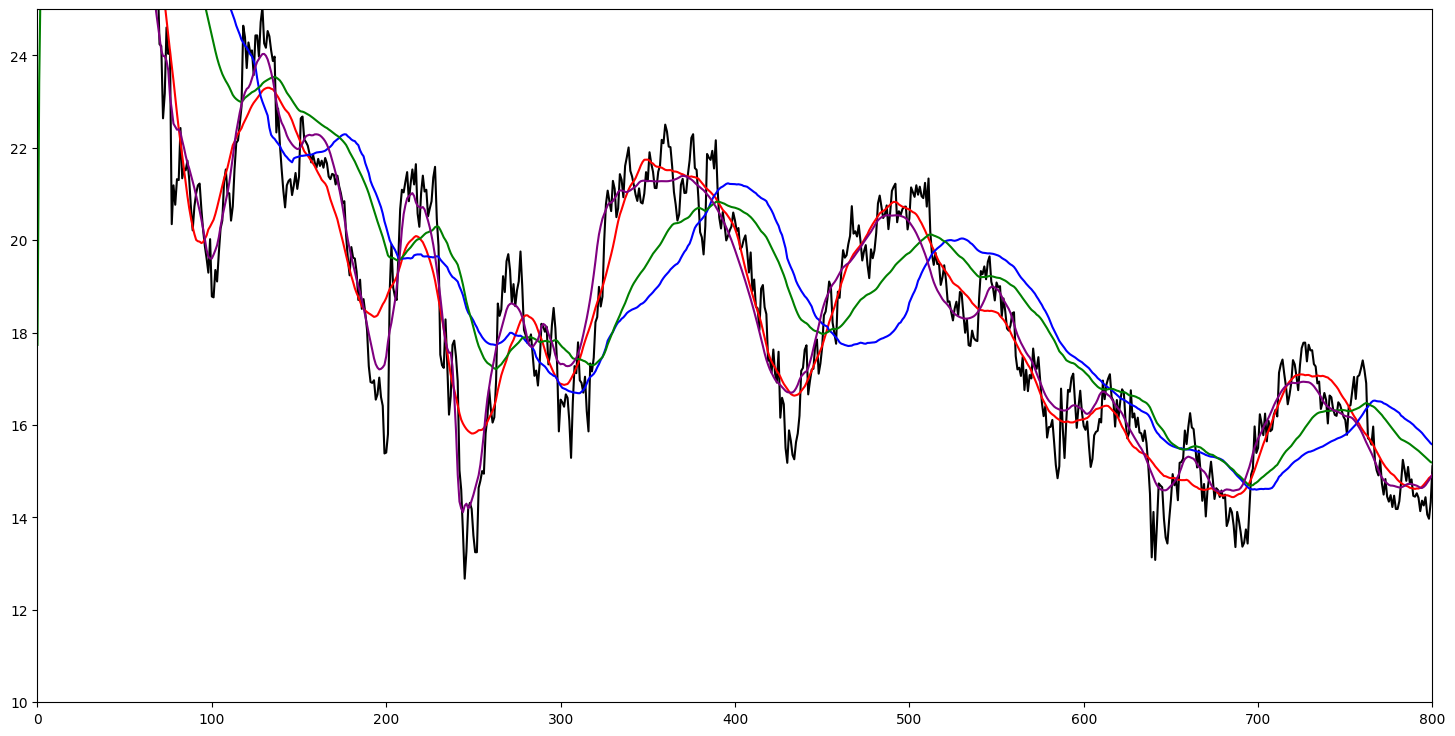

In [851]:
fig, ax = plt.subplots(figsize=(18, 9)) 
plt.plot(data["Close"], color = "black")
#plt.plot(data["AVG_P"])
#plt.plot(data["AVG_P2"])
plt.plot(data["savgol_price"], color = "red")
plt.plot(data["VWAP"], color = "blue")
plt.plot(data["trend"], color = "green")
#plt.plot(data["MA80"], color = "orange")
plt.plot(data["clean_price"], color = "purple")
#plt.plot(trend)
plt.xlim(0, 800)
plt.ylim(10,25)

In [818]:



def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def atr(df: pd.DataFrame, n: int = 14) -> pd.Series:
    h, l, c = df["High"], df["Low"], df["Close"]
    tr = pd.concat([(h - l), (h - c.shift()).abs(), (l - c.shift()).abs()], axis=1).max(axis=1)
    return tr.rolling(n).mean()

def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["ema50"] = ema(df["close"], 50)
    df["ema200"] = ema(df["close"], 200)

    df["roc20"] = df["close"].pct_change(20)
    df["roc60"] = df["close"].pct_change(60)

    df["vol20"] = df["close"].pct_change().rolling(20).std() * np.sqrt(252)
    df["atr14"] = atr(df, 14)

    # Trend strength proxy: EMA50 slope over ~1 month
    df["ema50_slope"] = (df["ema50"] - df["ema50"].shift(20)) / df["ema50"].shift(20)

    # Vol-adjusted momentum score
    df["mom_score"] = (0.5 * df["roc20"] + 0.5 * df["roc60"]) / (df["vol20"] + 1e-12)
    return df

def make_signals(df: pd.DataFrame, min_mom=0.10, max_vol=0.60) -> pd.DataFrame:
    df = df.copy()
    trend_ok = (df["close"] > df["ema50"]) & (df["ema50"] > df["ema200"]) & (df["ema50_slope"] > 0)
    mom_ok = df["mom_score"] > min_mom
    vol_ok = df["vol20"] < max_vol

    df["entry"] = trend_ok & mom_ok & vol_ok
    df["exit"] = (df["close"] < df["ema50"])  # simple trend-break exit
    return df

## Trend only tests

In [852]:
linreg0 = rolling_linreg_slope(data["clean_price"].shift(-1), window = 3)
linreg1 = rolling_linreg_slope(data["clean_price"].shift(-1), window = 10)
linreg2 = rolling_linreg_slope(data["clean_price"].shift(-1), window = 20)
data["linreg"] = linreg0
data["z_score_lr"] = (data["linreg"] - data["linreg"].rolling(window=20).mean()) / data["linreg"].rolling(window=20).std()
data["linreg_long"] = linreg2

linreg_0 = rolling_linreg_slope(data["savgol_price"].shift(-1), window = 3)
linreg_1 = rolling_linreg_slope(data["savgol_price"].shift(-1), window = 10)
linreg_2 = rolling_linreg_slope(data["savgol_price"].shift(-1), window = 20)
data["linreg2"] = linreg_0
data["z_score_lr2"] = (data["linreg2"] - data["linreg2"].rolling(window=20).mean()) / data["linreg2"].rolling(window=20).std()

In [853]:
data

Price,Close,High,Low,Open,Volume,AVG_P,AVG_P2,Returns_o,Returns_c,Returns_h,...,trend,VWAP,MA80,clean_price,savgol_price,linreg,z_score_lr,linreg_long,linreg2,z_score_lr2
0,35.601452,36.231397,34.207937,35.849612,53228400,35.429649,35.472599,NaN,NaN,NaN,...,17.736300,NaN,NaN,34.607997,36.156673,NaN,NaN,NaN,NaN,NaN
1,34.398830,35.773256,34.284295,34.685169,54119000,34.914240,34.785388,-1.164443,-1.202621,-0.458141,...,23.426901,NaN,NaN,35.271008,35.665939,NaN,NaN,NaN,NaN,NaN
2,34.761539,35.544199,33.406202,33.940701,64059600,34.297034,34.413160,-0.744468,0.362709,-0.229057,...,26.182381,NaN,NaN,36.249298,35.201925,-1.635640,NaN,NaN,-0.451015,NaN
3,33.597084,34.780618,33.100763,34.265208,54976600,34.048863,33.935918,0.324507,-1.164455,-0.763581,...,27.742064,NaN,NaN,31.999729,34.763909,-0.737799,NaN,NaN,-0.425379,NaN
4,34.036129,34.284289,32.776239,33.177113,62013600,33.412547,33.568442,-1.088095,0.439045,-0.496328,...,28.721842,NaN,NaN,34.773699,34.351167,-0.074604,NaN,NaN,-0.400466,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6386,448.601532,452.099235,447.335996,448.402251,16883500,449.279161,449.109754,-4.952596,-4.663605,-6.537018,...,412.063334,396.457926,399.076203,452.974565,460.118784,3.723009,0.095336,2.249071,3.897315,1.541838
6387,459.074707,459.333805,454.520723,454.879477,20974300,456.244668,456.952178,6.477225,10.473175,7.234570,...,413.460577,397.068641,399.807920,456.050409,464.052774,2.242590,-0.199775,1.705776,3.970117,1.540978
6388,455.756348,460.898259,455.327863,459.602829,17086300,458.609650,457.896325,4.723352,-3.318359,1.564454,...,414.843717,397.574237,400.566916,457.459745,468.059018,-0.652037,-0.708461,1.543050,4.041822,1.540095
6389,457.071747,460.101096,453.713568,459.931679,13974800,457.915448,457.704522,0.328850,1.315399,-0.797162,...,416.177833,397.965849,401.309948,454.746336,472.136417,-1.846647,-1.791373,1.420763,4.112429,1.539187


(4000.0, 4500.0)

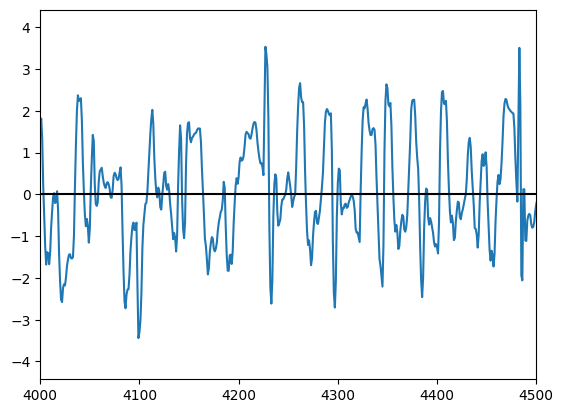

In [829]:
#plt.plot(linreg0, color = "blue")
#plt.plot(linreg1, color = "orange")
#plt.plot(linreg2, color = "red")
plt.plot(data["z_score_lr"])
plt.axhline(y=0, color = "black")
plt.xlim(4000,4500)
#plt.ylim(-5, 5)

In [821]:
data["VOL"] = data["Returns"].rolling(window = 20).std()
data["VOL-Z"] = (data["VOL"] - data["VOL"].rolling(window= 20).mean())/data["VOL"].rolling(window= 20).std()

(4000.0, 4800.0)

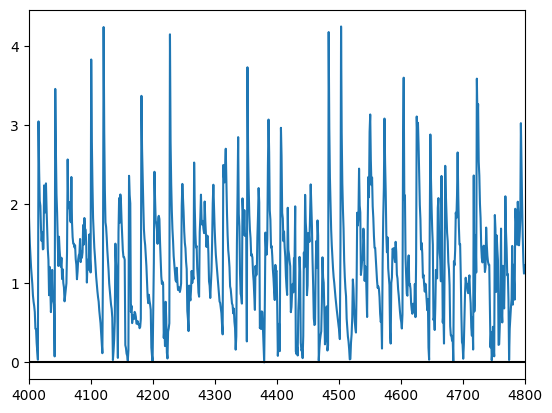

In [822]:
#plt.plot(linreg_0, color = "blue")
#plt.plot(linreg_1, color = "orange")
#plt.plot(linreg_2, color = "red")

#plt.plot(data["linreg"])
#plt.plot(data["z_score_lr"] , color = "red")
#plt.plot(data["z_score_lr2"], color = "green")
#plt.plot(data["VOL"])
plt.plot(abs(data["VOL-Z"]))
plt.axhline(y=0, color = "black")
plt.xlim(4000,4800)
#plt.ylim(0, 3)

In [823]:
data["Signal"] = 0

signal = [0]
b = True
for i in range(1, len(data)):
    s = 0
    #buy
    #if linreg_1[i] > 0 and linreg_2[i] > 0 and linreg_0[i] > 0:
    #if data["linreg"][i] >= 0.5*np.mean(data["linreg"][i-30:i]) and data["linreg_long"][i] > 0*np.mean(data["linreg_long"][i-20:i]) and b == True:
    if data["z_score_lr"][i] >= 0.5: #and data["z_score_lr2"][i] >= 0.5:
        s = 1
        b = False
        p = data["Close"][i]

    #elif np.mean(data["Returns"][i-20:i]) > 0.0002 and np.mean(data["Returns"][i-3:i]) < np.mean(data["Returns"][i-20:i]) and b == True:
        #s = 1
        #b = False
        #p = data["Close"][i]
    
    # sell
    #if linreg_1[i] > 0.02 and linreg_2[i] > 0.01 and linreg0[i] < 0:
    #if data["linreg"][i] < -0.5*np.mean(data["linreg"][i-30:i]) and data["linreg_long"][i] > -0*np.mean(data["linreg_long"][i-20:i]) and b == False:
        #if linreg_2[i] >= 0.05 and linreg_1[i] >= 0.05:
    if data["z_score_lr"][i] < -0.5: #and data["z_score_lr2"][i] < 0.5:
        s = -1
        b = True

    #elif np.mean(data["Returns"][i-20:i]) > 0.0002 and np.mean(data["Returns"][i-3:i]) > np.mean(data["Returns"][i-20:i]) and b == False:
        #s = -1
        #b = True
        
    #elif b == False and data["Close"][i] >= 1.05 * p:
        #s = -1
        #b = True

    elif b == False and (abs(data["VOL-Z"][i]) > 2.75 or abs(data["VOL-Z"][i]) <0.01):
        s = -1
        b = True    
    elif b == False and (data["Close"][i] <= 0.995 * p or data["Close"][i] >= 1.05 * p):
        s = -1
        b = True
    
    signal.append(s)

data["Signal"] = signal

In [824]:
# Example usage:
# bt = backtest_long_only_from_signal(df, price_col="Close", signal_col="signal", fee=0.001)
# print(bt[["Close","signal","position","equity"]].tail())
# +1 = buy, -1 = sell

bt = backtest_long_only_from_signal(data, price_col="Close", signal_col="Signal", fee=0.001)
initial_capital = 10_000  # set this to whatever you want

final_equity = bt["equity"].iloc[-1]          # e.g. 1.23 means +23%
total_return_pct = (final_equity - 1) * 100

final_value = initial_capital * final_equity
profit_money = final_value - initial_capital

print(f"Total return: {total_return_pct:,.2f}%")
print(f"Final value:  {final_value:,.2f}")
print(f"Profit:       {profit_money:,.2f}")
# Max drawdown
eq = bt["equity"]
drawdown = eq / eq.cummax() - 1
max_dd_pct = drawdown.min() * 100
print(f"Max drawdown: {max_dd_pct:.2f}%")

# Number of round-trip trades (buy+sell)
round_trips = int(bt["position"].diff().abs().sum() / 2)
print(f"Round trips:  {round_trips}")
import numpy as np

cagr = ((final_value/initial_capital)**(1/26) -1)*100

rf = 0.02        # 2% risk-free (annual)
periods = 252    # trading days

excess = bt["strat_ret"] - rf/periods

sharpe = np.sqrt(periods) * excess.mean() / excess.std()

print(f"Sharpe: {sharpe:.2f}")
print(f"CAGR; {cagr:.2f}%")

Total return: 4,419,154.60%
Final value:  441,925,460.08
Profit:       441,915,460.08
Max drawdown: -23.26%
Round trips:  342
Sharpe: 2.14
CAGR; 50.89%


In [ ]:
# 2.54


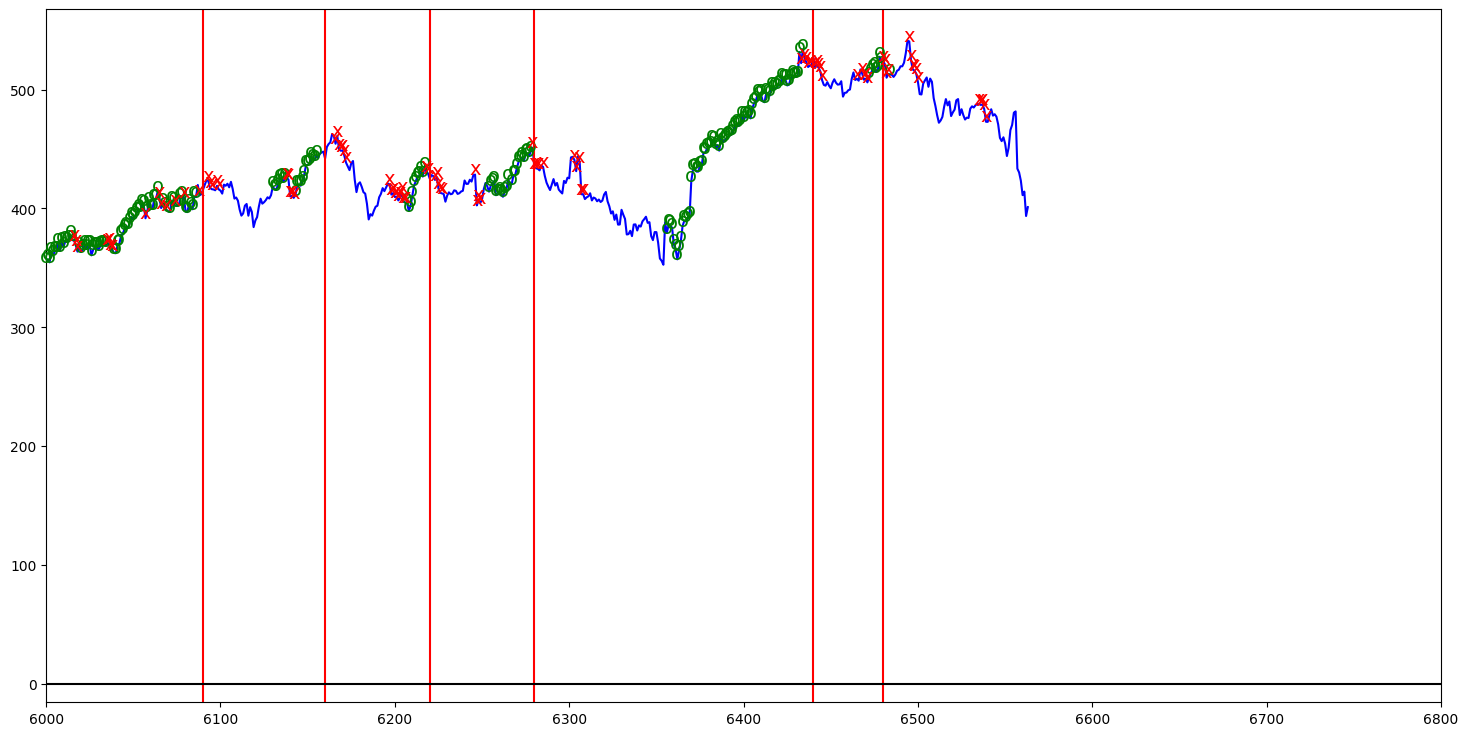

In [574]:
# 1. cutting points.
# 2. turning points.
data['long_signal'] = False
data['long_signal'] = (data["Signal"] == 1)
# Generate short (sell) signals
data['short_signal'] = False
data['short_signal'] = (data["Signal"] == -1)              #(dal_df["MA21D"] > 0.05) & (abs(dal_df["U"]) > 0) 

fig, ax = plt.subplots(figsize=(18, 9)) 

# Add arrows for long (buy) signals
long_signal_dates = data[data['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, data.loc[date, 'linreg']), color='green', fontsize=14, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = data[data['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, data.loc[date, 'linreg']), color='red', fontsize=14, ha='center')

plt.plot(data["Close"], color = "blue")

plt.xlim(6000,6800)
#plt.ylim(0,30)
plt.axvline(x = 6090, color = "red")
plt.axvline(x = 6160, color = "red")
plt.axvline(x = 6220, color = "red")
plt.axvline(x = 6280, color = "red")
plt.axvline(x = 6440, color = "red")
plt.axvline(x = 6480, color = "red")
plt.axhline(y = 0, color = "black")
plt.show()

In [552]:
#linreg0 
#linreg1 crosses 0 downward.
#linreg2 negative diff

#linreg_1 reaches 0 downward.
#linreg_2 negative diff

Total return: 1,178,060.96%
Final value:  117,816,095.66
Profit:       117,806,095.66
Max drawdown: -12.08%
Round trips:  199


In [396]:


#145597.31%, drawdown < 14.37%, 1.78 sharpe

# 112071%, drawdown < 32.53%, 1.31 sharpe

# 99280.4%, drawdown < 17.47%, 1.55 sharpe

# 93915%, drawdown < 22.5%, 1.47 sharpe

# 61710%, drawdown < 16%, 1.51 sharpe

# 62091%, drawdown < 18.7%, 1.48 sharpe

# 4214%, drawdown < 15.5%, 1.03 sharpe

# 68787.41%, drawdown < 33.85%, 1.21 sharpe

Sharpe: 2.29
CAGR; 45.38%


'20.523144275155648%'